<big><big>**Лабораторная работа по теме: "Асинхронное выполнение кода"**</big></big>

<big>Цель - ознакомиться с особенностями реализации асинхронного программирования в Python</big>

<big>Задача:</big>

<big>Реализовать простой асинхронно работающий сервер с возможностью множественного подключения, который в качестве запросов будет принимать последовательность символов длиной до 20 символов и возвращать ответ: является ли эта последовательность символов - последовательностью ДНК.</big>

1. Проверка последовательности

In [3]:
pip install biopython

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\sasha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
from Bio.Seq import Seq


In [10]:
class DNASequenceValidator:
    """Класс для проверки валидности последовательности ДНК с учётом символов IUPAC."""
    def is_valid_dna_sequence(sequence):
        """Проверяет, является ли последовательность допустимой ДНК."""
        # Допустимые символы IUPAC для ДНК (включая строчные буквы)
        valid_chars = set("ACGTURYSWKMBDHVN")
        return all(char in valid_chars for char in sequence)


In [11]:
import asyncio
import socket
from asyncio import AbstractEventLoop
async def echo(connection: socket,
    loop: AbstractEventLoop) -> None:
    while data := await loop.sock_recv(connection, 1024):
        await loop.sock_sendall(connection, data)
async def listen_for_connection(server_socket: socket,
    loop: AbstractEventLoop):
    while True:
        connection, address = await loop.sock_accept(server_socket)
        connection.setblocking(False)
        print(f"Получен запрос на подключение от {address}")
        asyncio.create_task(echo(connection, loop))

async def main():
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    server_address = ('127.0.0.1', 8000)
    server_socket.setblocking(False)
    server_socket.bind(server_address)
    server_socket.listen()
    await listen_for_connection(server_socket, asyncio.get_event_loop())
    asyncio.run(main())

2. Создание эхо-сервера, который дублирует ввод.

In [ ]:
import socket
# с помощью функции socket создается сокет

# socket.AF_INET, – тип адреса - имя хоста и номер порта, socket.SOCK_STREAM - будет использоваться протокол TCP
server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

# установка флага SO_REUSEADDR в 1. Это позволит повторно использовать номер порта.
server_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)

# привяжем сокет к адресу своего собственного компьютера 127.0.0.1 и выберем порт 34561
server_address = ('127.0.0.1', 34561)

# Теперь у сокета есть адрес – 127.0.0.1:34561
server_socket.bind(server_address)

# чтобы прослушивать запросы от клиентов, желающих подключиться к нашему серверу
server_socket.listen()

try:
    # ждем запроса на подключение с помощью метода accept. Этот метод блокирует программу до получения запроса, после чего возвращает объект подключения и адрес подключившегося клиента
    connection, client_address = server_socket.accept()
    print(f'Получен запрос на подключение от {client_address}!')
    buffer = b''
    while buffer[-2:] != b'\r\n':
        #  метод recv, который позволяет получать данные из сокета. Метод принимает целое число, показывающее, сколько байтов мы хотим прочитать.
        data = connection.recv(2) # зададим размер буфера заведомо малым.
        # Получив запрос, мы пытаемся принять два байта и сохранить их в буфере
        # Затем входим в цикл и на каждой итерации проверяем, заканчивается ли буфер символами возврата каретки и перевода строки.
        if not data:
            break
        else:
            print(f'Получены данные: {data}!')
            buffer = buffer + data
            
    # После получения '\r\n' мы выходим из цикла и печатаем все сообщение, полученное от клиента        
    print(f"Все данные: {buffer}")

    #  метод sendall принимает сообщение и отправляет его клиенту.
    connection.sendall(buffer)
#  закрываем серверный сокет в блоке finally. Таким образом, соединение будет гарантированно закрыто    
finally:
    server_socket.close()

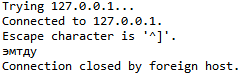

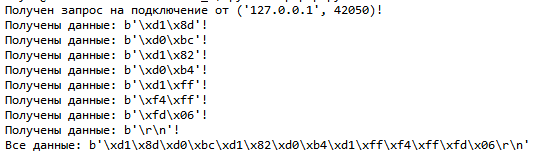

3. 

In [ ]:
import asyncio
import socket
import signal
from asyncio import AbstractEventLoop
from typing import List

class GracefulExit(SystemExit):
    # Определяет собственное исключение GracefulExit, которое будет использоваться для корректной остановки сервера.
    pass

async def shutdown(loop: AbstractEventLoop):

    """Функция завершения работы сервера."""

    print("\nПолучен сигнал завершения. Остановка сервера...")

    # Собирает все активные асинхронные задачи - asyncio.all_tasks()
    tasks = [t for t in asyncio.all_tasks() if t is not asyncio.current_task()] 
    for task in tasks:
        # Отправляет каждой задаче команду на отмену (task.cancel()).
        task.cancel()
    # Ждет завершения всех задач (asyncio.gather())    
    await asyncio.gather(*tasks, return_exceptions=True) # tasks - список всех задач кроме текущей, return_exceptions=True позволяет игнорировать исключения при отмене задач

    # Останавливает цикл событий
    loop.stop()

# Создадим сопрограмму echo, отвечающую за обработку данных, связанных с одним подключением. Получив данные, она будет отправлять их копию обратно клиенту.
async def echo(connection: socket.socket, loop: AbstractEventLoop) -> None: # socket.socket сокет клиента, AbstractEventLoop - цикл событий
    """Обрабатывает клиента и эхо-ответ."""
    while data := await loop.sock_recv(connection, 1024): # sock_recv ждет поступления байтов в сокет. 
        await loop.sock_sendall(connection, data) # sock_sendall принимает сокет и данные, которые нужно отправить, после чего ждет, пока все данные будут отправлены

async def listen_for_connection(server_socket: socket.socket, loop: AbstractEventLoop):

    """Ожидает входящие подключения."""
    while True:


        connection, address = await loop.sock_accept(server_socket) # возвращает кортеж (структуру данных, в которой хранится упорядоченная последовательность значений), состоящий из сокета и адреса клиента.
        connection.setblocking(False) # отключение блокировки для других клиентов
        print(f"Получен запрос на подключение от {address}")

        # После получения запроса на подключение создаем задачу echo, ожидающую данные от клиента
        asyncio.create_task(echo(connection, loop))

async def close_echo_tasks(echo_tasks: List[asyncio.Task]):
    """Закрывает все задачи с клиентами корректно."""
    # мы принимаем список задач echo и обертываем каждую из них задачей wait_for с двухсекундным тайм-аутом

    waiters = [asyncio.wait_for(task, 2) for task in echo_tasks]
    for task in waiters:
        try:
            await task # ожидаем все обернутые задачи с помощью await
        except asyncio.exceptions.TimeoutError:
            pass  # Игнорируем таймаут при завершении

async def main():
    """Основная функция сервера."""
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1) # функция, чтобы избежать проблем с повторным запуском
    server_socket.setblocking(False) # неблокирующий
    server_socket.bind(('127.0.0.1', 34561)) # привязывает сервер 127.0.0.1:34561
    server_socket.listen() # слушает входящие подключения

    loop = asyncio.get_running_loop() # текущий цикл

    print("Сервер запущен на 127.0.0.1:3451")

    # Ожидание ввода пользователя для завершения
    stop_event = asyncio.Event()
    asyncio.create_task(listen_for_connection(server_socket, loop)) # запуск функции listen_for_connection(), чтобы обрабатывать клиентов
    try:
        await stop_event.wait()  # Ждет, пока не будет вызван shutdown
    except asyncio.CancelledError:
        pass
    finally:
        # закрывает сокет и вызывает shutdown()
        server_socket.close()
        await shutdown(loop)

if __name__ == "__main__":
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    try:
        loop.run_until_complete(main())
    except KeyboardInterrupt:
        print("\nОстановка сервера...")
        loop.run_until_complete(shutdown(loop))
    finally:
        loop.close()
        print("Сервер остановлен.")

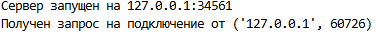

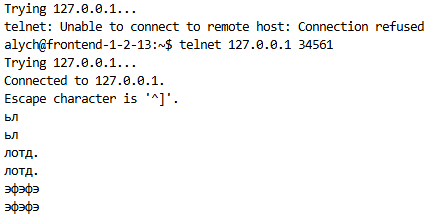

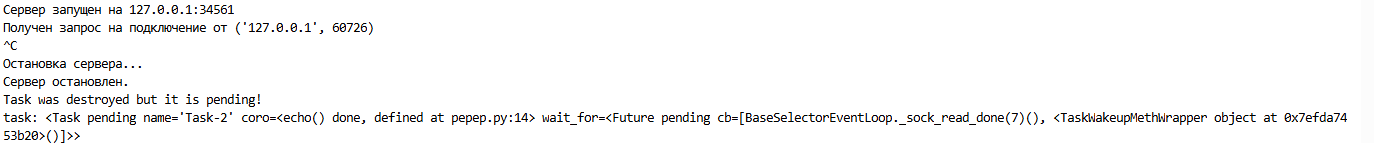

Этот код реализует асинхронный эхо-сервер, который:
Обрабатывает клиентов в отдельных async-задачах.

Поддерживает корректное завершение (graceful shutdown).

Работает на asyncio без блокировки.

4.

In [ ]:
import asyncio
import socket
from typing import List, Set
from asyncio import AbstractEventLoop
from Bio.Seq import Seq

# Функция проверки ДНК
def is_valid_dna_sequence(sequence):
    """Проверяет, является ли последовательность допустимой ДНК."""
    # Допустимые символы IUPAC для ДНК (включая строчные буквы)
    valid_chars = set("ACGTURYSWKMBDHVN")
    return all(char in valid_chars for char in sequence)

active_tasks: Set[asyncio.Task] = set()

class GracefulExit(SystemExit):
    # Определяет собственное исключение GracefulExit, которое будет использоваться для корректной остановки сервера.
    pass

async def shutdown(loop: AbstractEventLoop):

    """Функция завершения работы сервера."""

    print("\nПолучен сигнал завершения. Остановка сервера...")

    # Собирает все активные асинхронные задачи - asyncio.all_tasks()
    tasks = [t for t in asyncio.all_tasks() if t is not asyncio.current_task()] 
    for task in tasks:
        # Отправляет каждой задаче команду на отмену (task.cancel()).
        task.cancel()
    # Ждет завершения всех задач (asyncio.gather())    
    await asyncio.gather(*tasks, return_exceptions=True) # tasks - список всех задач кроме текущей, return_exceptions=True позволяет игнорировать исключения при отмене задач

    # Останавливает цикл событий
    loop.stop()

# Создадим сопрограмму echo, отвечающую за обработку данных, связанных с одним подключением. Получив данные, она будет отправлять их копию обратно клиенту.
async def echo(connection: socket.socket, loop: AbstractEventLoop) -> None: # socket.socket сокет клиента, AbstractEventLoop - цикл событий
    """Обрабатывает клиента и эхо-ответ."""
    while data := await loop.sock_recv(connection, 1024): # sock_recv ждет поступления байтов в сокет.
        message = data.decode().strip() # переменная, в которой содержится сообщение клиента

        # проверка, является ли сообщение последовательностью ДНК
        if is_valid_dna_sequence(message):
            response = f'Это последовательность ДНК - {message}\n'
        else:
            response = f'Не является последовательностью ДНК - {message}\n'

        await loop.sock_sendall(connection, response.encode()) # sock_sendall принимает сокет и данные, которые нужно отправить - response, после чего ждет, пока все данные будут отправлены

async def listen_for_connection(server_socket: socket.socket, loop: AbstractEventLoop):

    """Ожидает входящие подключения."""
    while True:


        connection, address = await loop.sock_accept(server_socket) # возвращает кортеж (структуру данных, в которой хранится упорядоченная последовательность значений), состоящий из сокета и адреса клиента.
        connection.setblocking(False) # отключение блокировки для других клиентов
        print(f"Получен запрос на подключение от {address}")

        # После получения запроса на подключение создаем задачу echo, ожидающую данные от клиента
        asyncio.create_task(echo(connection, loop))

async def close_echo_tasks(echo_tasks: List[asyncio.Task]):
    """Закрывает все задачи с клиентами корректно."""
    # мы принимаем список задач echo и обертываем каждую из них задачей wait_for с двухсекундным тайм-аутом

    waiters = [asyncio.wait_for(task, 2) for task in echo_tasks]
    for task in waiters:
        try:
            await task # ожидаем все обернутые задачи с помощью await
        except asyncio.exceptions.TimeoutError:
            pass  # Игнорируем таймаут при завершении

async def main():
    """Основная функция сервера."""
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1) # функция, чтобы избежать проблем с повторным запуском
    server_socket.setblocking(False) # неблокирующий
    server_socket.bind(('127.0.0.1', 34563)) # привязывает сервер 127.0.0.1:34563
    server_socket.listen() # слушает входящие подключения

    loop = asyncio.get_running_loop() # текущий цикл

    print("Сервер запущен на 127.0.0.1:3453")

    # Ожидание ввода пользователя для завершения
    stop_event = asyncio.Event()
    asyncio.create_task(listen_for_connection(server_socket, loop)) # запуск функции listen_for_connection(), чтобы обрабатывать клиентов
    try:
        await stop_event.wait()  # Ждет, пока не будет вызван shutdown
    except asyncio.CancelledError:
        pass
    finally:
        # закрывает сокет и вызывает shutdown()
        server_socket.close()
        await shutdown(loop)

if __name__ == "__main__":
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    try:
        loop.run_until_complete(main())
    except KeyboardInterrupt:
        print("\nОстановка сервера...")
        loop.run_until_complete(shutdown(loop))
    finally:
        loop.close()
        print("Сервер остановлен.")

Результат:


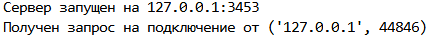

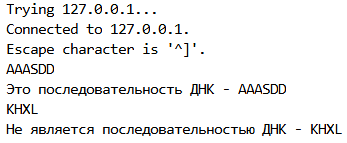

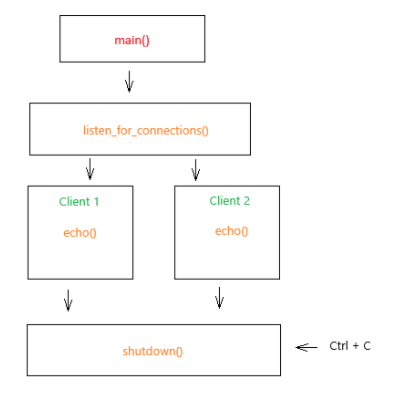

1. Цикл событий запускает корутину main()

2. В main() запускается корутина listen_for_connection, которая в ожидании новых подключений.


3. Как только клиент подключается, listen_for_connection передает управление корутине echo(), которая будет отвечать на запросы клиента.


4. Пока одна корутина (например, echo()) ждет ответа, цикл событий может переключиться на другие задачи.


5. В случае завершения работы вызывается shutdown, который завершает все задачи и останавливает цикл событий.

<big>Вывод:</big>

Был реализован простой асинхронно работающий сервер с возможностью множественного подключения, который в качестве запросов принимает последовательность символов длиной до 20 символов и возвращает ответ: является ли эта последовательность символов - последовательностью ДНК.
